In [136]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from math import log, e

In [371]:
# светлый (яркий): 4 155 37
# тёмный: 0 75 37
# светлый (бледный): 199 233 20
dano = "#FFDD2D"
green = '#049B25'
palette = [green, dano]

In [1418]:
h_crop_predecessor = 'crop_predecessor.isin(["Оз.пшеница мягкая", "Яр.пшеница мягкая", "Соя", "Чечевица","Люцерна 1 г.ж.корм", "Кукуруза зерно"])'
h_crop = 'crop.isin(["Яр.пшеница мягкая", "Яр.ячмень", "Соя", "Люцерна пр.лет корм", "Кукуруза зерно"])'
h_region = 'region.isin(["Воронеж", "Калуга", "Рязань", "Татарстан", "Курск"])'

# Чтение файлов

In [436]:
#читаем рекорды
records = pd.read_csv('рекорды_культуры.csv', encoding='cp1251')
records.index = records.crop
records = records.record

In [1192]:
#читаем works
df_works = pd.read_csv('works.csv', sep=';', encoding='cp1251')
df_works.columns = df_works.iloc[1, :]
df_works = df_works.iloc[2:, :]
df_works.index -= 2

for column in ['area', 'proc_depth', 'prod_dry_perc', 'prod_weight', 'prod_humid', 'prod_impur', 'yield_fact']:
    df_works[column] = df_works[column].str.replace(',', '.').astype('float64')

df_works['yield_fact'] = pd.Series(df_works['prod_weight'][i] / df_works['area'][i] if df_works['prod_weight'][i] > 0 else np.nan for i in range(len(df_works)))

#стандартизация в единицах измерения
for i in df_works['yield_fact'].index:
    if df_works.loc[i, 'yield_fact'] > 500:
        df_works.loc[i, 'yield_fact'] = df_works.loc[i, 'yield_fact'] / 1000
df_works = df_works[(df_works['yield_fact'] < 100) | (df_works['yield_fact'].isna())].drop_duplicates(subset=['work_id'])
df_works.index = pd.Series(range(len(df_works)))

#изменяем тип на строки
df_works['season'] = df_works['season'].astype('str')

#Добавляем столбик с логарифмом урожайности, так лучше очищается слишком маленькая урожайность
df_works['yield_log'] = pd.Series(i**.5 if i > 0 else np.nan for i in df_works['yield_fact'])

#добавляем культуры - crop
cultures = df_fields.pivot(
    index='field',
    columns='season',
    values='crop'
)
df_works['crop'] = pd.Series(
    cultures.loc[df_works.loc[i,'field'],
    df_works.loc[i, 'season']] if df_works['field'][i] in cultures.index else np.nan for i in df_works.index
)

C:\Users\user\AppData\Local\Temp\ipykernel_752\3462503296.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_works = pd.read_csv('works.csv', sep=';', encoding='cp1251')


In [1500]:
#читаем fields
df_fields = pd.read_csv('fields.csv', sep=';', encoding ='cp1251')
df_fields.columns = df_fields.iloc[0, :]
df_fields = df_fields.iloc[2:, :-1]
df_fields.index -= 2

for column in ['area','yield_plan','k2o','p2o5','humus','ph']:
    df_fields[column] = df_fields[column].str.replace(',','.').astype('float64')
df_fields['season'] = df_fields['season'].astype('str')

# #Добавляем логарифмы химических показателей
df_fields['k2o_log'] = df_fields['k2o'].apply(lambda x: np.nan if x <= 0 else x).apply(log)
df_fields['p2o5_log'] = df_fields['p2o5'].apply(lambda x: np.nan if x <= 0 else x).apply(log)
df_fields['humus_log'] = df_fields['humus'].apply(lambda x: np.nan if x <= 0 else x).apply(log)

## Объединение культур

In [1510]:
df_fields = df_fields.replace({
    "Кукуруза зерно": "Кукуруза",
    "Кукуруза гибрид": "Кукуруза",
    "Кукуруза силос": "Кукуруза",
    # 'Люцерна 1 г.ж.корм': 'Люцерна',
    # 'Люцерна пр.лет корм': 'Люцерна',
    "Чечевица зеленая": "Чечевица",
    'Чечевица красная': 'Чечевица',
    'Эспарцет 1 г.ж.корм': 'Эспарцет',
    'Эспарцет пр.лет корм': 'Эспарцет'
})

# #дропаем свеколку
df_fields = df_fields.query('crop != "Cах.свекла"') 
df_fields = df_fields.query('crop != "Cах. свекла"') 


In [767]:
df_fields.delta.isna().value_counts()

delta
False    7453
True     5342
Name: count, dtype: int64

## Создаём переменную delta

In [1501]:
#Считаем общую массу собранного урожая для каждого поля в works
#(y_f - сводная таблица по урожаю)
df_works.index = pd.Series(range(len(df_works)))
df_works['yield_fact_absolute'] = df_works['yield_fact'] * df_works['area']
y_f = df_works.groupby(['season', 'field'], as_index=False).agg({'yield_fact_absolute':'sum'})

#Считаем общую площадь, которая использовалась для работы, для каждого поля в works
#(area_f - сводная таблица по площади)
df_works['area_for_yield'] = pd.Series([df_works['area'][i] * (df_works['yield_fact'][i] > 0) for i in range(len(df_works))])
area_f = df_works.groupby(['season', 'field'], as_index=False).agg({'area_for_yield':'sum'})

#создаём массив для бд fields, в котором указываем общую массу собранного урожая для каждого поля
#(переносим данные из сводной таблицы по массе урожая)
yf2 = y_f.pivot(index='field', columns='season', values='yield_fact_absolute')
yield_abs = []
yf2.columns = pd.Series(['2023', '2024'])
for i in range(len(df_fields)):
    if df_fields['field'][i] in yf2.index:
        yield_abs.append(yf2.loc[df_fields['field'][i], df_fields['season'][i]])
    else:
        yield_abs.append(np.nan)

#создаём массив для бд fields, в котором указываем общую площадь, которая использовалась для работы, для каждого поля из fields
#(переносим данные из сводной таблицы по площади полей)
af2 = area_f.pivot(index='field', columns='season', values='area_for_yield')
af2.columns = pd.Series(['2023','2024'])
area_abs=[]
for i in range(len(df_fields)):
    if df_fields['field'][i] in af2.index:
        area_abs.append(af2.loc[df_fields['field'][i], df_fields['season'][i]])
    else:
        area_abs.append(np.nan)
df_fields['yield_fact'] = pd.Series(yield_abs)/pd.Series(area_abs)

#delta = фактическая урожайность / плановая урожайность
df_fields['delta'] = (df_fields['yield_fact'] / df_fields['yield_plan']).replace([np.inf, -np.inf], np.nan)

## Добавление неорганических удобрений

In [1502]:
df_works['chem'] = df_works['work_subtype'].apply(lambda x: x == "Внесение минеральных удобрений" or x == 'Внесение СЗР и удобрений')
chemic = df_works.groupby(['season','field'],as_index=False).agg({'chem': 'sum'}).pivot(index='field', values='chem', columns='season')
df_fields['chem_used'] = pd.Series([int(chemic.loc[df_fields.loc[i, 'field'], df_fields.loc[i, 'season']] >= 1) if df_fields.loc[i, 'field'] in chemic.index else np.nan for i in range(len(df_fields))])

In [1304]:
sns.histplot(x=df_fields[(df_fields.crop != 'Пар') & (df_fields.crop != 'Залежь, лес')].crop, hue=df_fields.nan, multiple='stack', palette=palette, legend=True)
sns.despine(offset=10, trim=True)
plt.xticks(rotation=90)
plt.xlabel('Культуры')
plt.ylabel('Количество')

AttributeError: 'DataFrame' object has no attribute 'nan'

In [1713]:
#читаем values
df_value = pd.read_csv('value.csv', sep=';', encoding='cp1251')
df_value.columns = df_value.iloc[1, :]
df_value = df_value.iloc[2:, :]
df_value.index -= 2

for column in ['inv_item_weight', 'inv_item_dose']:
  df_value[column] = df_value[column].str.replace(',', '.').astype('float64')

# Чистим выбросы

## Works

In [534]:
#Отдельно для каждой культуры (crop) и типа получения урожая (work_subtype)
std_yield = df_works[(df_works['yield_fact'] > 0)]
std_yield = std_yield.groupby(['work_subtype','crop'],as_index=False).agg({'yield_log':'std'}).pivot(index = 'crop', columns = 'work_subtype',values = 'yield_log')
mean_yield = df_works[(df_works['yield_fact'] > 0)]
mean_yield = mean_yield.groupby(['work_subtype','crop'],as_index=False).agg({'yield_log':'mean'}).pivot(index = 'crop', columns = 'work_subtype',values = 'yield_log')

z = []
for i in range(len(df_works)):
    if not(df_works['crop'][i] in mean_yield.index and df_works['work_subtype'][i] in mean_yield.columns):
        z.append(0)
        continue
    stdi = std_yield.loc[df_works['crop'][i], df_works['work_subtype'][i]]
    mi = mean_yield.loc[df_works['crop'][i], df_works['work_subtype'][i]]
    if stdi == 0 or pd.isna(mi):
        z.append(0)
        continue
    z.append((df_works['yield_log'][i]-mi) / stdi)
    
df_works['z_yield'] = pd.Series(z)
df_works = df_works[(df_works['z_yield'] > -2) & (df_works['z_yield'] < 2)]

## Fields

Чистка fields по IQR убирает Nan => мешает для графиков в нанами

In [1190]:
sns.violinplot(y=df_fields.delta, color=dano)
sns.despine(offset=10, trim=True)
plt.ylabel('Delta')

AttributeError: 'DataFrame' object has no attribute 'delta'

Добавляем год в value

In [440]:
df_value['inv_item_date'] = pd.to_datetime(df_value['inv_item_date'])
df_value["season"] = df_value["inv_item_date"].dt.year

C:\Users\user\AppData\Local\Temp\ipykernel_752\2229718657.py:1: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_value['inv_item_date'] = pd.to_datetime(df_value['inv_item_date'])


### Чистка по рекордам

In [1504]:
for cr in records.index:
    rec = records[cr]
    df_fields = df_fields.query(f'(yield_fact < @rec) | (crop != @cr)')
df_fields.index = pd.Series(range(len(df_fields)))

### Чистка по IQR

In [1505]:
df_fields['z'] = stats.zscore(df_fields['delta'].apply(log), nan_policy='omit')
df_fields['delta_log'] = df_fields['delta'].apply(lambda x: x if x >= 0 else np.nan)

Q1 = df_fields.delta_log.quantile(0.25)
Q3 = df_fields.delta_log.quantile(0.75)
IQR = Q3 - Q1
df_fields = df_fields.query(f'@Q1 - 1.5*@IQR < delta_log & delta_log < @Q3 + 1.5*@IQR')
df_fields.index = pd.Series(range(len(df_fields)))

### Чистка по культурам

In [1506]:
crops_df = df_fields.groupby(['crop'], as_index=False).agg({'field': 'count'})
bigcrops = crops_df[crops_df['field'] > 100].loc[:, 'crop']
df_fields = df_fields.query(f'crop.isin(@bigcrops)')
df_fields.index = pd.Series(range(len(df_fields)))

C:\Users\user\AppData\Local\Temp\ipykernel_752\1216267923.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_fields, x='crop', y='yield_fact', palette='deep')


Text(0.5, 0, 'Культуры')

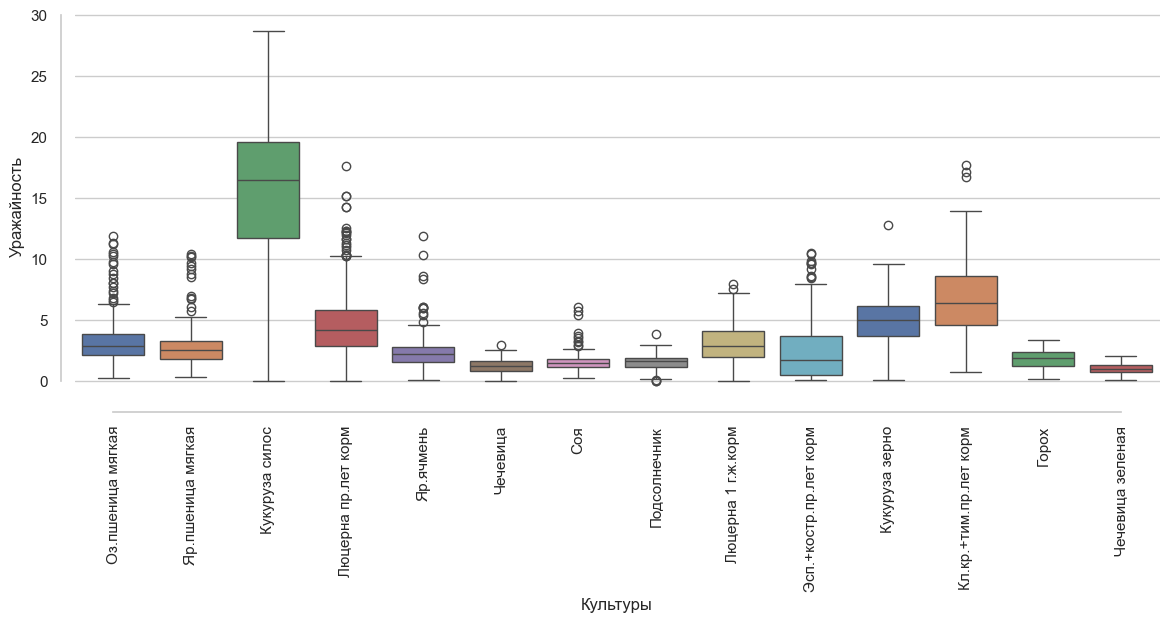

In [1507]:
plt.xticks(rotation=90)
sns.boxplot(data=df_fields, x='crop', y='yield_fact', palette='deep')
sns.despine(offset=10, trim=True)
plt.xticks(rotation=90)
plt.ylabel('Уражайность')
plt.xlabel('Культуры')

### Чистим прошлые культуры

In [1508]:
crops_predecessor = df_fields.groupby(['crop_predecessor'], as_index=False).agg({'field': 'count'})
bigcrops_predecessor = crops_predecessor[crops_predecessor['field'] > 100].loc[:, 'crop_predecessor']
df_fields = df_fields.query(f'crop_predecessor.isin(@bigcrops_predecessor)')
df_fields.index = pd.Series(range(len(df_fields)))

In [1509]:
#считаем наны в дельте для понимания 
df_fields['nan'] = np.where(df_fields.delta.isna(), '1', '0')
df_fields.nan.value_counts()

nan
0    5642
Name: count, dtype: int64

# Строим графики

### Урожайность для разных культур

Text(0, 0.5, 'Количество полей')

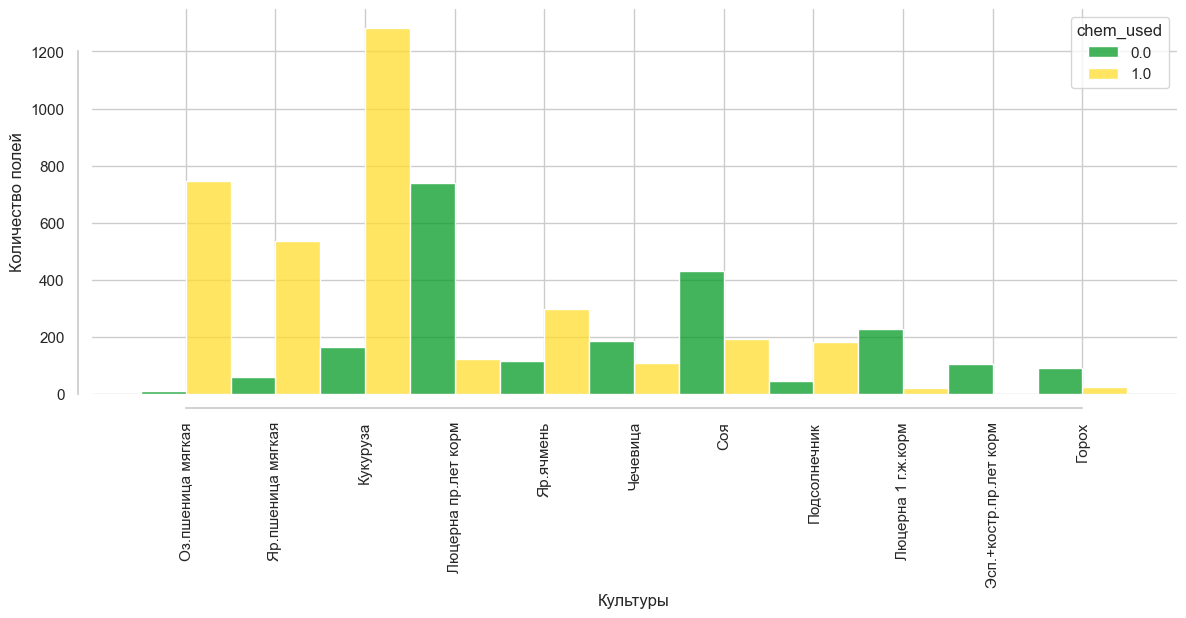

In [1311]:
crops_df = df_fields.groupby(['crop'], as_index=False).agg({'delta': 'count'})
bigcrops = crops_df[crops_df['delta'] > 100].loc[:, 'crop']
df_f3 = df_fields.query(f'crop.isin(@bigcrops)')
sns.histplot(data=df_f3, x='crop', hue='chem_used', multiple="dodge", palette=palette, legend=True)
sns.despine(offset=10, trim=True)
plt.xticks(rotation=90)
plt.xlabel('Культуры')
plt.ylabel('Количество полей')

Text(0, 0.5, 'Количество полей')

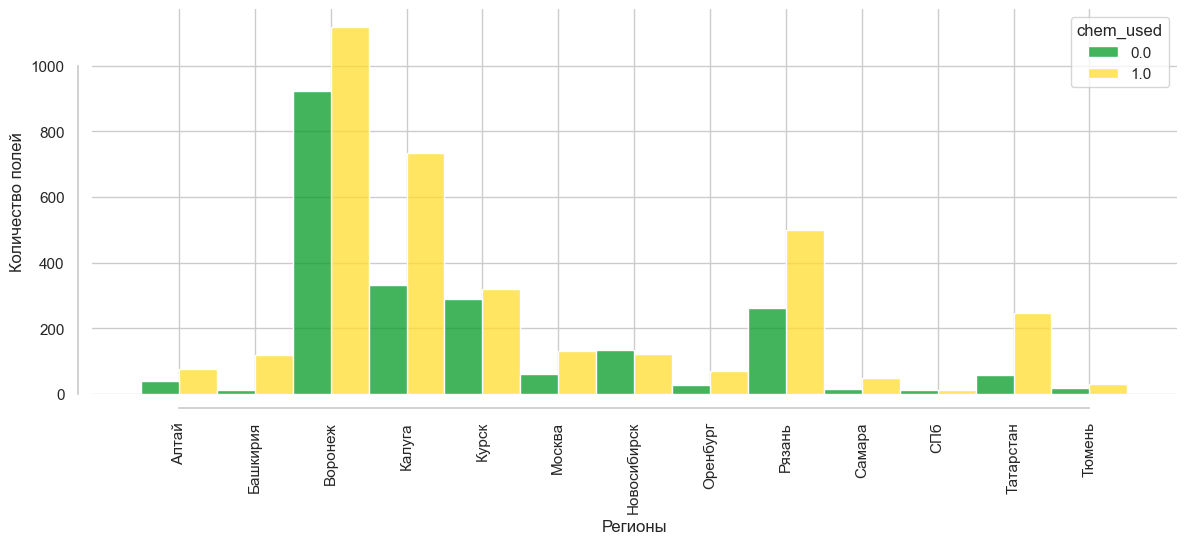

In [1312]:
crops_df = df_fields.groupby(['crop'], as_index=False).agg({'delta': 'count'})
bigcrops = crops_df[crops_df['delta'] > 100].loc[:, 'crop']
df_f3 = df_fields.query(f'crop.isin(@bigcrops)')
sns.histplot(data=df_f3, x='region', hue='chem_used', multiple="dodge", palette=palette, legend=True)
sns.despine(offset=10, trim=True)
plt.xticks(rotation=90)
plt.xlabel('Регионы')
plt.ylabel('Количество полей')

Text(0, 0.5, 'Фактическая урожайность')

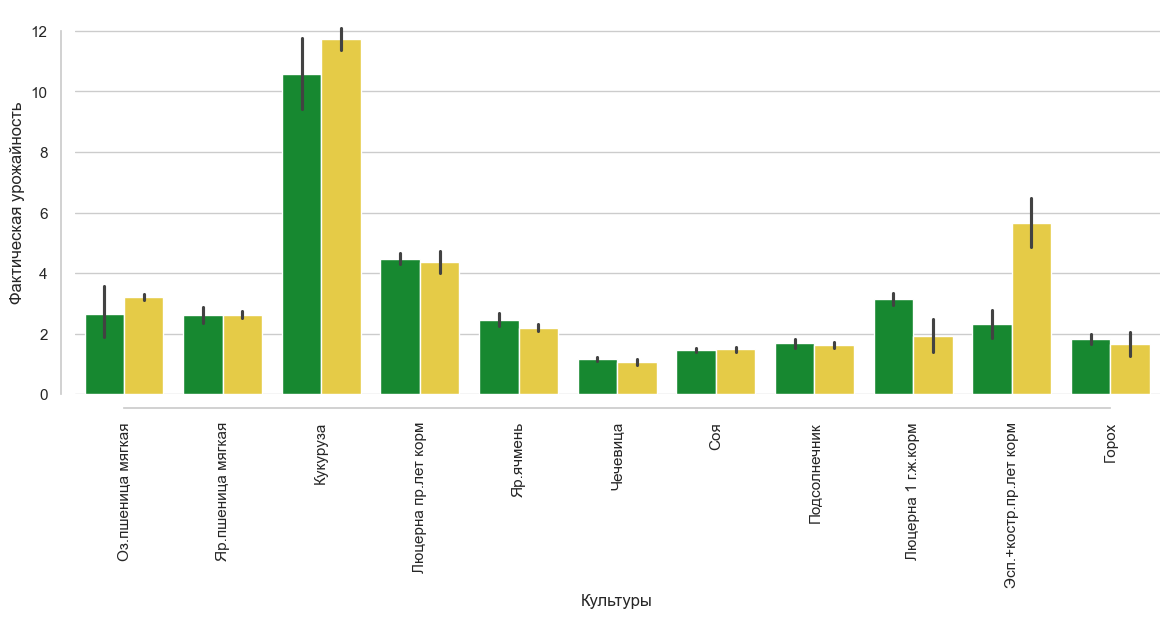

In [1313]:
crops_df = df_fields.groupby(['crop'], as_index=False).agg({'delta': 'count'})
bigcrops = crops_df[crops_df['delta'] > 100].loc[:, 'crop']
df_f3 = df_fields.query(f'crop.isin(@bigcrops)')

sns.barplot(data=df_f3, y='yield_fact', x='crop', hue='chem_used', palette=palette, legend=False)
sns.despine(offset=10, trim=True)
plt.xticks(rotation=90)
plt.xlabel('Культуры')
plt.ylabel('Фактическая урожайность')

## Текущие ультуры

In [360]:
sns.set_theme()
sns.set_style("whitegrid")
font = {'fontname': 'monospace', 'color':  'royalblue', 'weight': 'bold', 'size': 18}
title_font = {'fontname': 'monospace', 'color':  'slategrey', 'weight': 'bold', 'size': 24}

Text(0, 0.5, 'Количество записей')

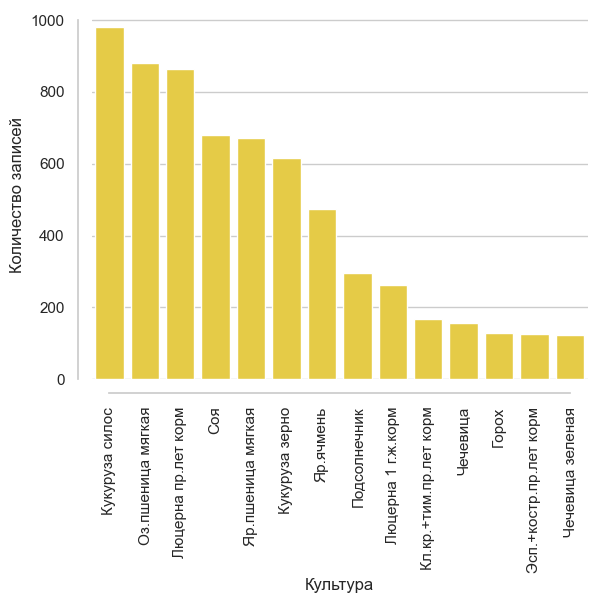

In [817]:
sns.barplot(df, y='count', x='crop', color=dano)
sns.despine(offset=10, trim=True)
plt.xticks(rotation=90)
plt.xlabel('Культура')
plt.ylabel('Количество записей')

In [ ]:
sns.barplot(data=df_fields, x='', y='', hue='chem_used')

C:\Users\user\AppData\Local\Temp\ipykernel_752\2037126387.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df_fields.replace(d), y='delta', x='chem_used', palette=palette[::-1])


Text(0, 0.5, 'Урожайность')

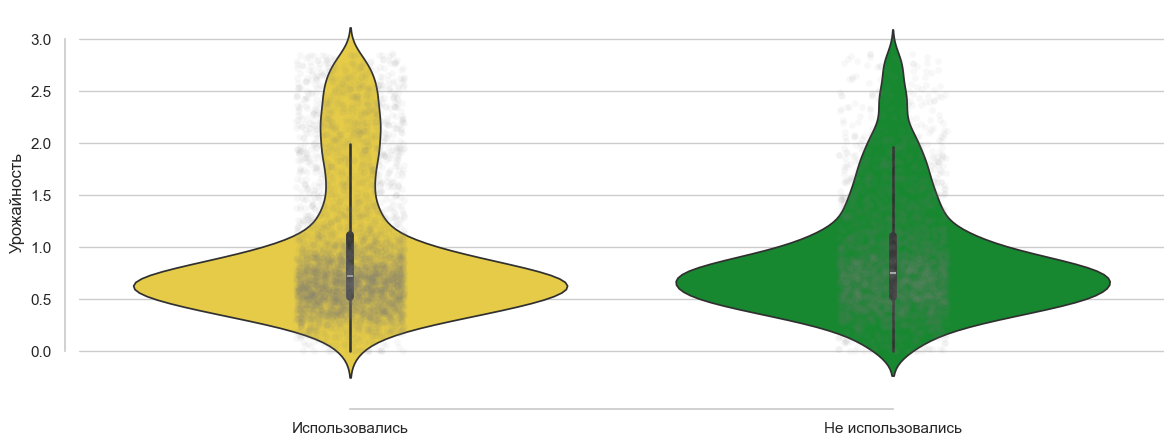

In [944]:
d = {0: 'Не использовались', 1: "Использовались"}
sns.violinplot(df_fields.replace(d), y='delta', x='chem_used', palette=palette[::-1])
sns.stripplot(df_fields.replace(d), y='delta', x='chem_used', alpha=.05, color='gray')
sns.despine(offset=10, trim=True)
plt.xlabel('')
plt.ylabel('Урожайность')

Text(0, 0.5, 'Количество полей')

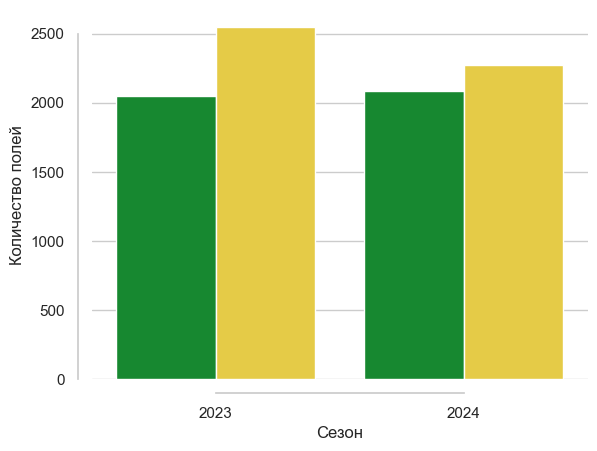

In [819]:
seasons = df_fields.groupby(['season', 'chem_used']).agg('count').reset_index()
sns.barplot(data=seasons, y='field', x='season', hue='chem_used', legend=False, palette=palette)
sns.despine(offset=10, trim=True)
plt.xlabel('Сезон')
plt.ylabel('Количество полей')

Text(0.5, 1.0, 'Культуры')

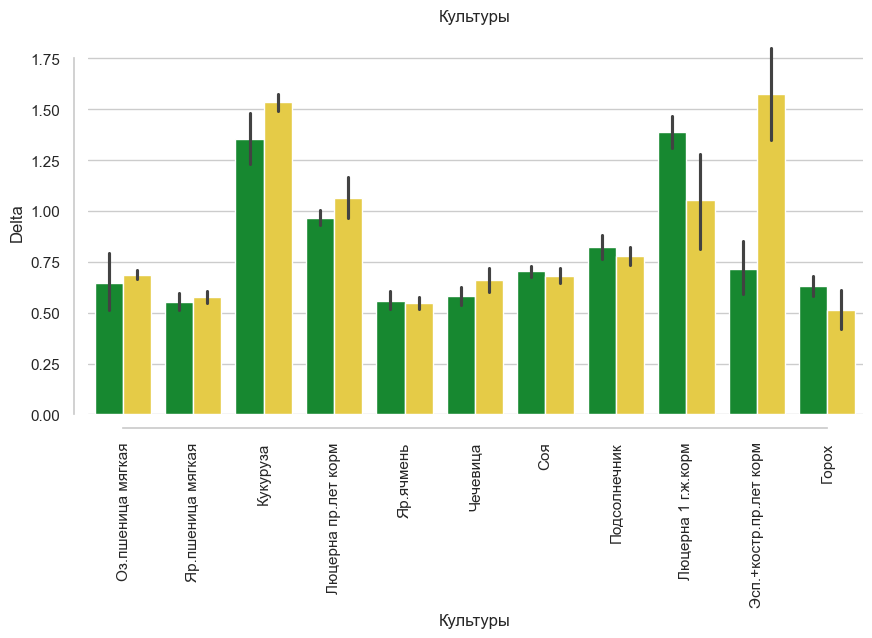

In [ ]:
sns.barplot(data=df_fields, y='delta', x='crop', hue='chem_used', palette=palette, legend=False)

plt.rcParams['figure.figsize'] = 10, 5
sns.despine(offset=10, trim=True)
plt.xticks(rotation=90)
plt.xlabel('Культуры')
plt.ylabel('Delta')

plt.title('Культуры')

## Предыдущие культуры 

In [1511]:
df_f3 = df_fields.query(f'delta > 0 & {h_crop_predecessor}')

Text(0.5, 1.0, 'Устойчивость по прошлым культурам')

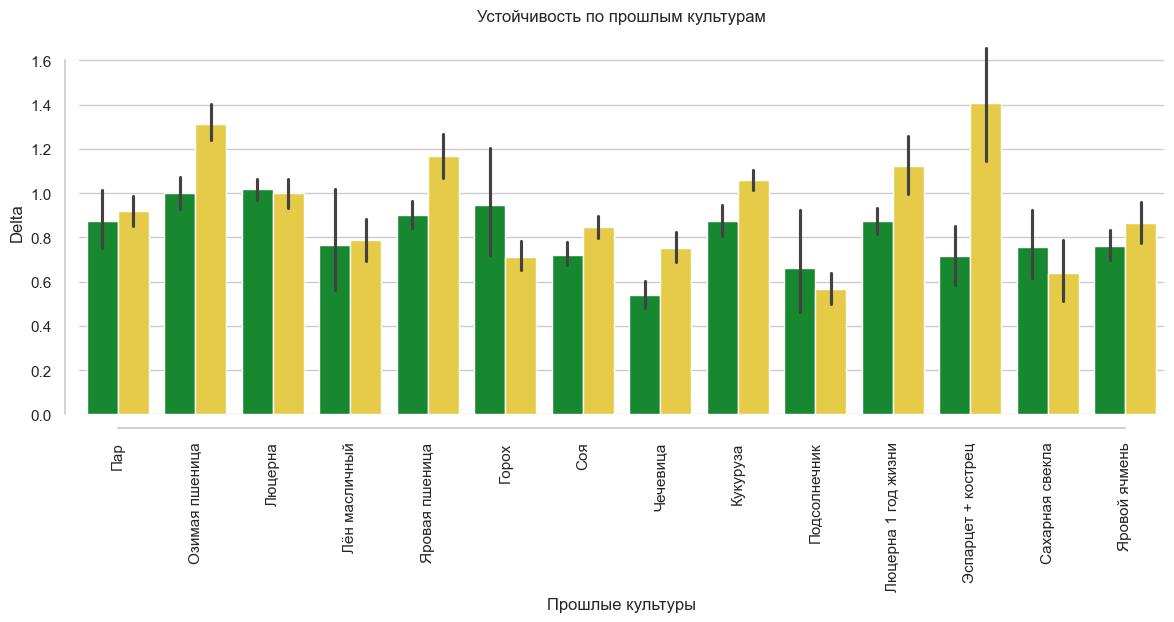

In [1512]:
crops_precedecessor_df = df_fields.groupby(['crop_predecessor'], as_index=False).agg({'field': 'count'})
bigcrop_predecessor = crops_precedecessor_df[crops_precedecessor_df['field'] > 100].loc[:, 'crop_predecessor']
df_predecessor = df_fields.query(f'crop_predecessor.isin(@bigcrop_predecessor)')

names = {
    "Люцерна 1 г.ж.корм": "Люцерна 1 год жизни",
    "Люцерна пр.лет корм": "Люцерна",
    "Эсп.+костр.пр.лет корм": "Эспарцет + кострец",
    "Оз.пшеница мягкая": "Озимая пшеница",
    "Яр.пшеница мягкая": "Яровая пшеница",
    "Яр.ячмень": "Яровой ячмень",
    "Сах.свекла": "Сахарная свекла"
}

predecessor = df_predecessor.query(f'delta > 0').replace(names)

sns.barplot(data=predecessor, y='delta', x='crop_predecessor', hue='chem_used', palette=palette, legend=False)

plt.rcParams['figure.figsize'] = 14, 5
sns.despine(offset=10, trim=True)
plt.xticks(rotation=90)
plt.xlabel('Прошлые культуры')
plt.ylabel('Delta')

plt.title('Устойчивость по прошлым культурам')

Text(0.5, 1.0, 'Урожайность прошлых культур')

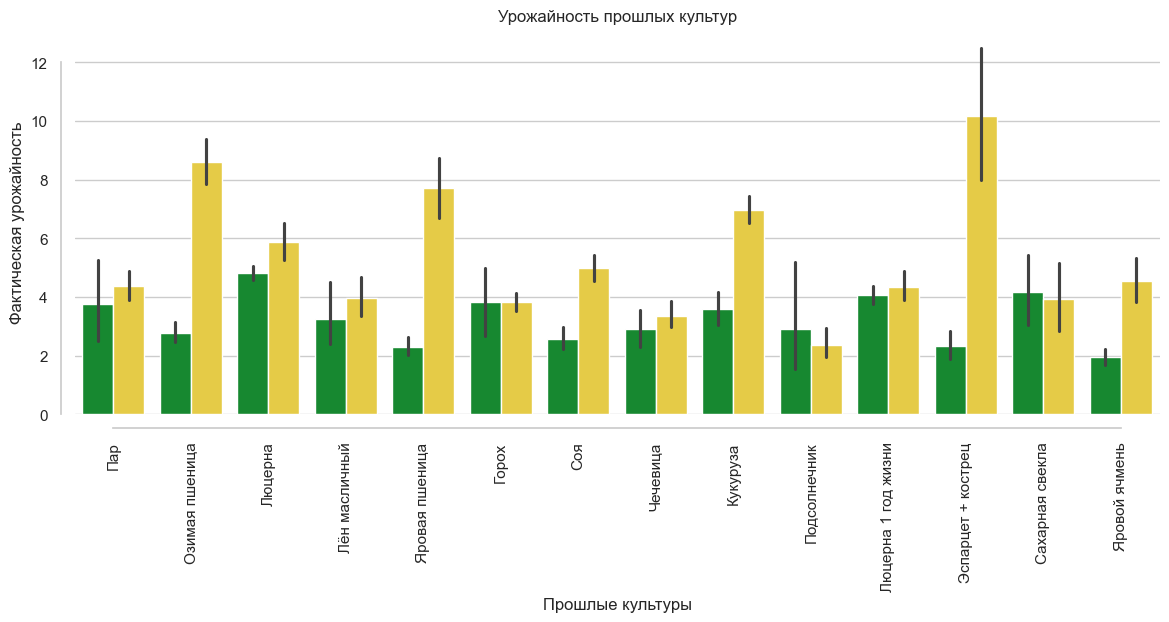

In [1513]:
#фактическая урожайность прошлых
sns.barplot(data=df_fields.replace(names), x='crop_predecessor', y='yield_fact', hue='chem_used', legend=False, palette=palette)

plt.rcParams['figure.figsize'] = 14, 5
sns.despine(offset=10, trim=True)
plt.xticks(rotation=90)
plt.xlabel('Прошлые культуры')
plt.ylabel('Фактическая урожайность')

plt.title('Урожайность прошлых культур')

## Регионы

Text(0.5, 1.0, 'Количество регионов')

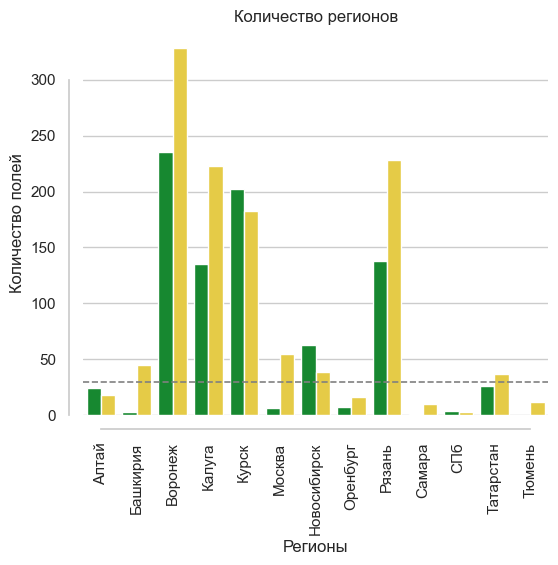

In [1515]:
#смотрим на регионы
sns.countplot(data=df_f3, x='region', hue='chem_used', palette=palette, legend=False)

plt.rcParams['figure.figsize'] = 14, 5
sns.despine(offset=10, trim=True)
plt.xticks(rotation=90)
plt.xlabel('Регионы')
plt.ylabel('Количество полей')
plt.axhline(30, color='grey', linewidth=1.2, linestyle='--')
plt.title('Количество регионов')


Text(0.5, 1.0, 'Устойчивость по регионам')

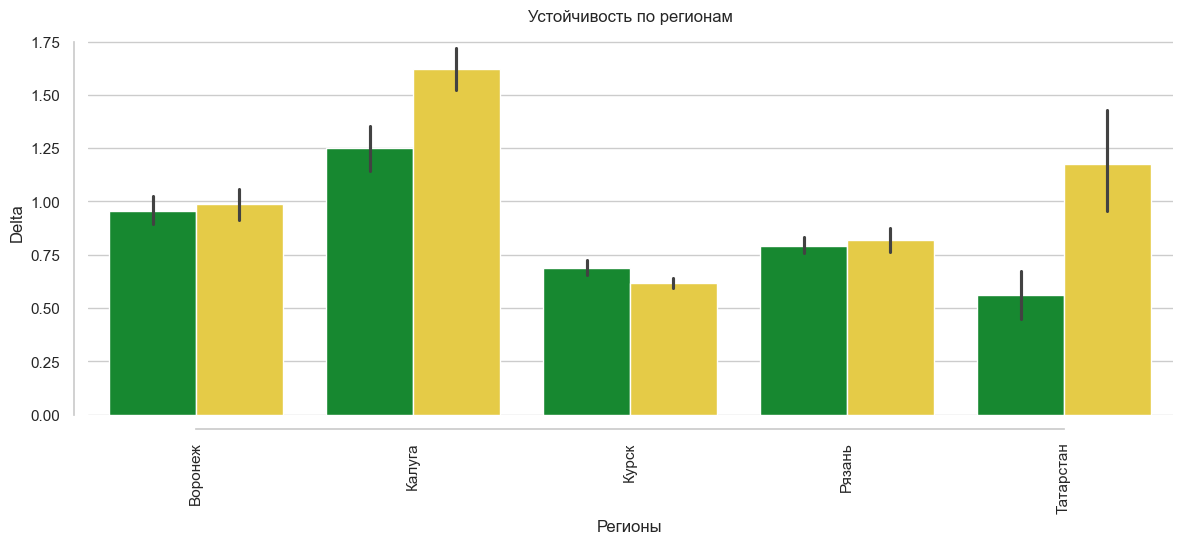

In [1514]:
#график подходящих регионов
df_region = df_f3.query(f'{h_region}')

sns.barplot(
    data=df_region,
    x='region',
    y='delta',
    hue='chem_used',
    palette=palette, legend=False
)

plt.rcParams['figure.figsize'] = 6, 5
sns.despine(offset=10, trim=True)
plt.xticks(rotation=90)
plt.xlabel('Регионы')
plt.ylabel('Delta')

plt.title('Устойчивость по регионам')

Text(0.5, 1.0, 'Изучаем Курск')

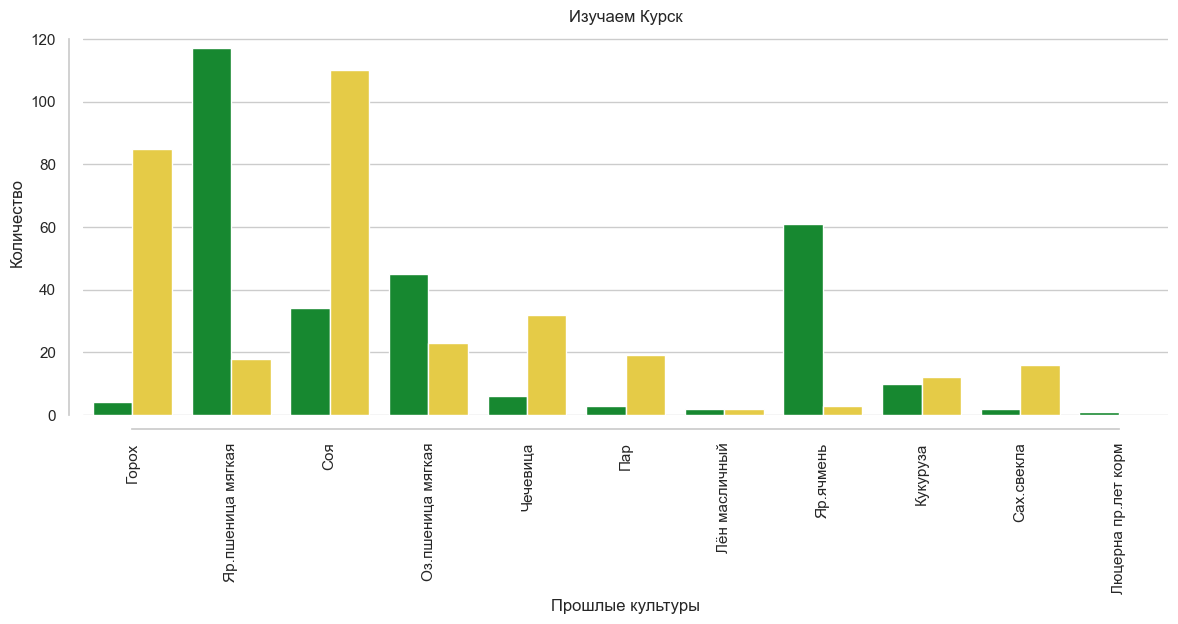

In [1516]:
#изучаем Курск

sns.countplot(
    data = df_fields.query('region == "Курск"'),
    x = 'crop_predecessor',
    hue = 'chem_used',
    palette=palette,
    legend=False
)

plt.rcParams['figure.figsize'] = 6, 5
sns.despine(offset=10, trim=True)
plt.xticks(rotation=90)
plt.ylabel('Количество')
plt.xlabel('Прошлые культуры')
plt.xticks(rotation=90)

plt.title('Изучаем Курск')

Text(0.5, 1.0, 'Изучаем Рязань')

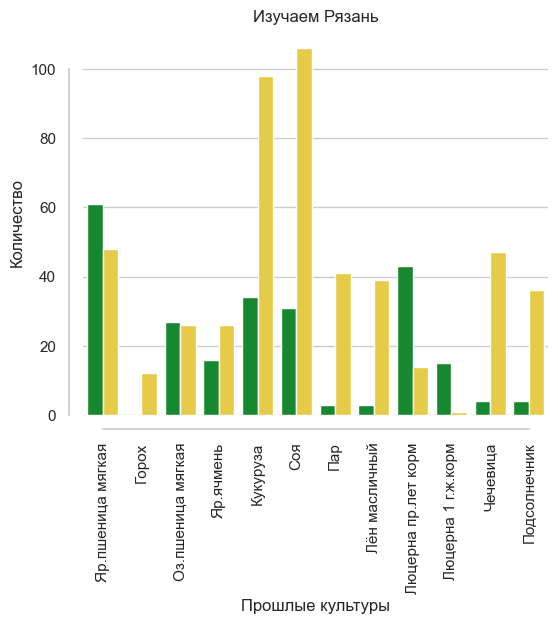

In [1518]:
#изучаем Рязань

sns.countplot(
    data = df_fields.query('region == "Рязань"'),
    x = 'crop_predecessor',
    hue = 'chem_used',
    palette=palette,
    legend = False
)

plt.rcParams['figure.figsize'] = 6, 5
sns.despine(offset=10, trim=True)
plt.xticks(rotation=90)
plt.ylabel('Количество')
plt.xlabel('Прошлые культуры')
plt.xticks(rotation=90)

plt.title('Изучаем Рязань')

# Т-тесты

## Строим кукушки

### QQ-прошлая культура

In [1780]:
df_fields.crop_predecessor.value_counts()

crop_predecessor
Кукуруза                  1423
Люцерна пр.лет корм        856
Оз.пшеница мягкая          546
Соя                        536
Яр.пшеница мягкая          485
Пар                        354
Люцерна 1 г.ж.корм         322
Яр.ячмень                  255
Лён масличный              195
Чечевица                   152
Эсп.+костр.пр.лет корм     143
Горох                      138
Подсолнечник               132
Сах.свекла                 105
Name: count, dtype: int64

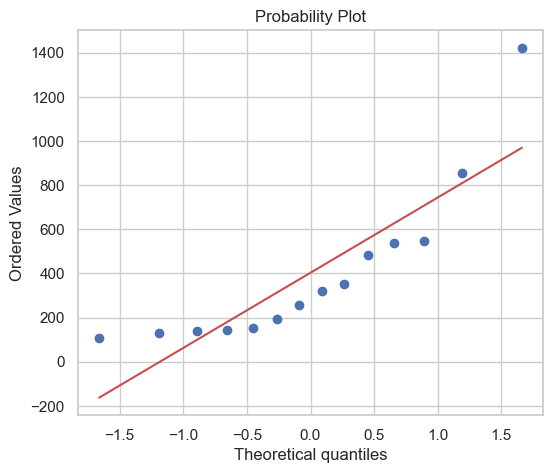

In [1781]:
import numpy as np 
import pylab 
import scipy.stats as stats

stats.probplot(df_fields.crop_predecessor.value_counts(), dist="norm", plot=pylab)
pylab.show()

## Т-тесты для текущих культур

In [1400]:
df_t = df_fields.replace(names)

for cr in list(df_t.crop.value_counts().reset_index().query('count > 100').crop):
  test = stats.ttest_ind(
      a=df_t[(df_t.crop == cr) & (df_t.chem_used == 0)].yield_fact.dropna(),
      b=df_t[(df_t.crop == cr) & (df_t.chem_used == 1)].yield_fact.dropna(),
      equal_var=True)

  if test.pvalue > 0.000:
    print(f'{str(test.pvalue < 0.05):6} {cr:20} {round(test.pvalue, 4)}')

False  Кукуруза             0.0556
False  Люцерна              0.6884
False  Озимая пшеница       0.1729
False  Соя                  0.5159
False  Яровая пшеница       0.9447
True   Яровой ячмень        0.029
True   Люцерна 1 год жизни  0.0006
False  Чечевица             0.5915
False  Подсолнечник         0.5324
False  Горох                0.3826
False  Эспарцет + кострец   0.0588


## Т-тест предыдущих культур

In [1519]:
print('Т-тест для предыдущих культур')
predecessor_t = df_fields.query(f'delta > 0 & {h_crop_predecessor} & {h_crop}')

for cr in list(df_fields.crop_predecessor.value_counts().reset_index().query('count > 100').crop_predecessor):
  test = stats.ttest_ind(
      a=predecessor_t[(predecessor_t.crop == cr) & (predecessor_t.chem_used == 0)].delta.dropna(),
      b=predecessor_t[(predecessor_t.crop == cr) & (predecessor_t.chem_used == 1)].delta.dropna(),
      equal_var=True)
  
  if test.pvalue > 0.000:
    print(f'{str(test.pvalue < 0.05):6} {cr:20} {round(test.pvalue, 4)}')

Т-тест для предыдущих культур
True   Люцерна пр.лет корм  0.0006
False  Соя                  0.9648
True   Яр.пшеница мягкая    0.0377
False  Яр.ячмень            0.6231


C:\Users\user\AppData\Local\Temp\ipykernel_752\2759899299.py:5: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  test = stats.ttest_ind(


## Т-тест регионов

In [1520]:
print('Т-тест для регионов')
region_t = df_f3.query(f'{h_region}')

for r in list(region_t.region.value_counts().reset_index().region):
  test = stats.ttest_ind(
    a=region_t[(region_t.region == r) & (region_t.chem_used == 0)].delta.dropna(),
    b=region_t[(region_t.region == r) & (region_t.chem_used == 1)].delta.dropna(),
    equal_var=True
  )

  if test.pvalue > 0.000:
    print(f'{str(test.pvalue < 0.05):6} {r:20} {round(test.pvalue, 4)}')

Т-тест для регионов
False  Воронеж              0.5746
True   Курск                0.0019
False  Рязань               0.5436
True   Калуга               0.0
True   Татарстан            0.0002


# Решающие деревья

## Добавляем сидераты

In [1642]:
df_fields['siderate'] = np.where(df_fields.crop_predecessor.isin(["Оз.пшеница мягкая", "Яр.пшеница мягкая", "Соя", "Чечевица","Люцерна 1 г.ж.корм", "Кукуруза зерно"]), "0", "1")

## Добавляем количественный chem_used

In [1711]:
df_value["inv_item_unit"].value_counts()

inv_item_unit
кг    31047
т      7862
л      3097
м3      999
шт        1
Name: count, dtype: int64

In [1714]:
df_value = df_value[df_value['inv_item_type'] == "Удобрения"]
merged_value = df_value.merge(df_works[['work_id', 'chem', 'season', 'area']], on='work_id', how='left')

merged_value['inv_item_weight'] = merged_value.apply(
     lambda row: 0 if row['chem'] == 0 else row['inv_item_weight'], axis=1
 )

final_value = merged_value
final_value['dose'] = final_value['inv_item_weight'] / final_value['area']
final_value['dose_fixed'] = final_value['dose']
df_l = final_value[final_value['inv_item_unit'] == 'л']
df_kg = final_value[final_value['inv_item_unit'] == 'кг']
df_m3 = final_value[final_value['inv_item_unit'] == 'м3']
df_t = final_value[final_value['inv_item_unit'] == 'т']
df_l['inv_item_weight'] = df_l['inv_item_weight'] / 1000
df_kg['inv_item_weight'] = df_kg['inv_item_weight'] / 1000
final_value = pd.concat([df_l, df_kg, df_m3, df_t])
agg_value = final_value.groupby(['field', 'season'], as_index=False).agg(
    dose_mean=('dose', 'mean'),
    inv_item_weight_sum=('inv_item_weight', 'sum')
)

df_fields_notsider = df_fields.query(f'delta > 0')
final_aggregated = agg_value.merge(df_fields_notsider[['field', 'season', 'delta', 'area','chem_used']], on=['field', 'season'], how='left')

C:\Users\user\AppData\Local\Temp\ipykernel_752\3776496434.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_l['inv_item_weight'] = df_l['inv_item_weight'] / 1000
C:\Users\user\AppData\Local\Temp\ipykernel_752\3776496434.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kg['inv_item_weight'] = df_kg['inv_item_weight'] / 1000


In [1718]:
fin = final_aggregated[final_aggregated['area'].notna()]
fin

,field,season,dose_mean,inv_item_weight_sum,delta,area,chem_used
0,02.09.02.002.01,2023,15632.500042,1879.80813,0.793549,120.25,1.0
4,02.09.02.015.00,2023,4724.200055,171.67743,0.616790,36.34,1.0
6,02.09.02.019.00,2023,4951.050020,502.82864,0.755098,50.78,1.0
11,02.09.06.004.04,2024,4944.727688,562.36388,0.525932,37.91,1.0
14,02.09.06.011.02,2023,4476.623663,807.00827,0.950753,101.78,1.0
...,...,...,...,...,...,...,...
7949,72.22.10.019.00,2024,28.782043,3186.46000,2.531562,110.71,1.0
7950,72.22.10.020.00,2024,28.340000,3089.06000,2.585109,109.00,1.0
7951,72.22.10.021.00,2024,14.079011,762.66000,2.139135,54.17,1.0
7954,72.22.10.024.00,2023,192846.134001,33259.79389,0.565385,30.00,1.0


In [1720]:
fin["valid_mean"] = fin['inv_item_weight_sum'] / fin['area']
fin

C:\Users\user\AppData\Local\Temp\ipykernel_752\2736897575.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fin["valid_mean"] = fin['inv_item_weight_sum'] / fin['area']


,field,season,dose_mean,inv_item_weight_sum,delta,area,chem_used,valid_mean
0,02.09.02.002.01,2023,15632.500042,1879.80813,0.793549,120.25,1.0,15.632500
4,02.09.02.015.00,2023,4724.200055,171.67743,0.616790,36.34,1.0,4.724200
6,02.09.02.019.00,2023,4951.050020,502.82864,0.755098,50.78,1.0,9.902100
11,02.09.06.004.04,2024,4944.727688,562.36388,0.525932,37.91,1.0,14.834183
14,02.09.06.011.02,2023,4476.623663,807.00827,0.950753,101.78,1.0,7.928947
...,...,...,...,...,...,...,...,...
7949,72.22.10.019.00,2024,28.782043,3186.46000,2.531562,110.71,1.0,28.782043
7950,72.22.10.020.00,2024,28.340000,3089.06000,2.585109,109.00,1.0,28.340000
7951,72.22.10.021.00,2024,14.079011,762.66000,2.139135,54.17,1.0,14.079011
7954,72.22.10.024.00,2023,192846.134001,33259.79389,0.565385,30.00,1.0,1108.659796


In [1722]:
fin_qwq = fin[fin['valid_mean'] >= 100]
fin_qwq['valid_mean'] = fin_qwq['valid_mean'] / 1000
fin_norm = fin[fin['valid_mean'] < 100]
fin = fin_norm
fin

,field,season,dose_mean,inv_item_weight_sum,delta,area,chem_used,valid_mean
0,02.09.02.002.01,2023,15632.500042,1879.80813,0.793549,120.25,1.0,15.632500
4,02.09.02.015.00,2023,4724.200055,171.67743,0.616790,36.34,1.0,4.724200
6,02.09.02.019.00,2023,4951.050020,502.82864,0.755098,50.78,1.0,9.902100
11,02.09.06.004.04,2024,4944.727688,562.36388,0.525932,37.91,1.0,14.834183
14,02.09.06.011.02,2023,4476.623663,807.00827,0.950753,101.78,1.0,7.928947
...,...,...,...,...,...,...,...,...
7944,72.22.10.015.00,2024,11.518017,2550.78000,0.514224,110.73,1.0,23.036034
7948,72.22.10.019.00,2023,0.000000,0.00000,0.274447,110.71,0.0,0.000000
7949,72.22.10.019.00,2024,28.782043,3186.46000,2.531562,110.71,1.0,28.782043
7950,72.22.10.020.00,2024,28.340000,3089.06000,2.585109,109.00,1.0,28.340000


In [1723]:
df_fields = df_fields.merge(fin[['field','season','valid_mean']], on=['field','season'], how='left')

In [1724]:
df_fields

,field,region,land_type,fertility_score,season,crop,crop_predecessor,crop_yearold,area,hybrid,...,yield_fact,delta,chem_used,z,delta_log,nan,sīdere,sidere,siderate,valid_mean
0,22.47.01.003.00,Алтай,пашня,4,2023,Оз.пшеница мягкая,Пар,NaN,452.25,Скипетр,...,2.602189,0.684787,1.0,-0.250557,0.684787,0,1,1,1,29.012422
1,22.47.01.004.00,Алтай,пашня,3,2023,Оз.пшеница мягкая,Пар,NaN,269.64,Скипетр,...,2.837487,0.746707,1.0,-0.152542,0.746707,0,1,1,1,23.748662
2,22.47.01.006.02,Алтай,пашня,2,2023,Оз.пшеница мягкая,Пар,NaN,63.33,Скипетр,...,2.186326,0.575349,1.0,-0.447721,0.575349,0,1,1,1,10.295012
3,22.47.01.007.02,Алтай,пашня,3,2023,Оз.пшеница мягкая,Пар,NaN,85.55,Скипетр,...,2.106955,0.554462,1.0,-0.489590,0.554462,0,1,1,1,12.577109
4,22.47.01.008.00,Алтай,пашня,3,2023,Оз.пшеница мягкая,Пар,NaN,32.32,Скипетр,...,2.029394,0.534051,1.0,-0.532058,0.534051,0,1,1,1,8.193120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5637,72.22.10.010.01,Тюмень,пашня,3,2024,Кукуруза,Люцерна пр.лет корм,NaN,79.07,Росс 130,...,11.792083,1.814167,1.0,0.852585,1.814167,0,1,1,1,20.553054
5638,72.22.10.015.00,Тюмень,пашня,3,2024,Яр.ячмень,Кукуруза,NaN,110.73,Эксплоер,...,1.799783,0.514224,1.0,-0.574895,0.514224,0,1,1,1,23.036034
5639,72.22.10.019.00,Тюмень,пашня,4,2024,Кукуруза,Люцерна пр.лет корм,NaN,110.71,Северина,...,16.455153,2.531562,1.0,1.229869,2.531562,0,1,1,1,28.782043
5640,72.22.10.020.00,Тюмень,пашня,2,2024,Кукуруза,Люцерна пр.лет корм,NaN,109.00,Смесь сортов,...,16.803211,2.585109,1.0,1.253569,2.585109,0,1,1,1,28.340000


## Считаем дерево

In [1643]:
df_fields.columns

Index(['field', 'region', 'land_type', 'fertility_score', 'season', 'crop',
       'crop_predecessor', 'crop_yearold', 'area', 'hybrid', 'reproduction',
       'seed_origin', 'technology', 'yield_plan', 'p2o5', 'k2o', 'humus', 'ph',
       'k2o_log', 'p2o5_log', 'humus_log', 'yield_fact', 'delta', 'chem_used',
       'z', 'delta_log', 'nan', 'sīdere', 'sidere', 'siderate'],
      dtype='object', name=0)

In [1757]:
df_regressor_siderate = df_fields.loc[:, ['valid_mean', 'crop_predecessor', 'region', 'siderate']].query('siderate == "1"').drop('siderate', axis=1)

In [1758]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

In [1759]:
le = LabelEncoder()
df_regressor_siderate['region'] = le.fit_transform(df_regressor_siderate['region'])
# df_regressor_siderate['crop'] = le.fit_transform(df_regressor_siderate['crop'])
df_regressor_siderate['crop_predecessor'] = le.fit_transform(df_regressor_siderate['crop_predecessor'])

In [1760]:
x_test, x_train, y_test, y_train = train_test_split(df_regressor_siderate, df_fields.query('siderate == "1"').loc[:, ['delta']], test_size=.2, random_state=42)

In [1761]:
regressor = RandomForestRegressor(max_depth=10)
regressor = regressor.fit(x_test, y_test)

c:\Users\user\Documents\DANO_2024\dano\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


valid_mean: 0.55219
crop_predecessor: 0.21403
region: 0.23377


C:\Users\user\AppData\Local\Temp\ipykernel_752\3670658044.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = [x for x in features_names], y = features, palette='deep')


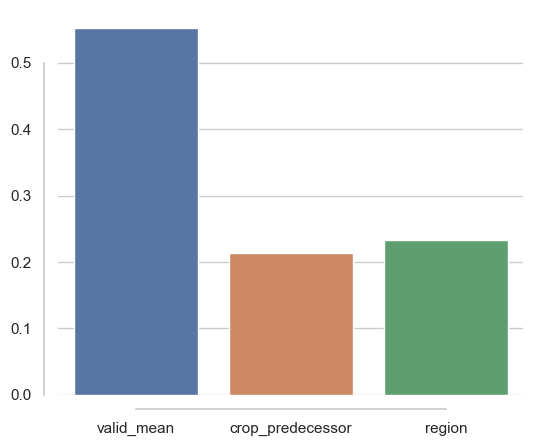

In [1764]:
features = regressor.feature_importances_
features_names = regressor.feature_names_in_

for i in range(len(features_names)):
    print(f'{features_names[i]}: {features[i]:.5f}')
sns.barplot(x = [x for x in features_names], y = features, palette='deep')
plt.rcParams['figure.figsize'] = 6, 5
sns.despine(offset=10, trim=True)
# plt.xlabel('Сезон')
# plt.ylabel('Количество полей')

## Дисперсионный анализ

In [1703]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

data = df_fields

formula = 'delta ~ chem_used + siderate + chem_used:siderate'
model = ols(formula, data).fit()
aov_table = anova_lm(model, typ=2)
print(aov_table)

                         sum_sq      df          F        PR(>F)
siderate               3.360364     1.0   8.113064  4.410649e-03
chem_used             11.556063     1.0  27.900274  1.325247e-07
chem_used:siderate     2.593301     1.0   6.261112  1.236977e-02
Residual            2335.213049  5638.0        NaN           NaN


<Axes: xlabel='chem_used', ylabel='delta'>

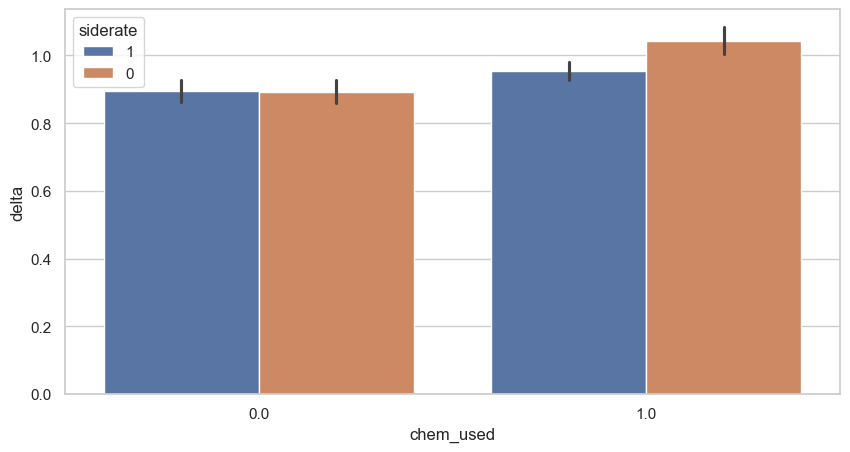

In [ ]:
sns.barplot(data=df_fields, x='chem_used', y='delta', hue='siderate')